## Step 2: Training a simple model

In [1]:
import os

print(f"Previous exec path: {os.getcwd()}")
# move two level up
os.chdir("../../")
print(f"Current exec path: {os.getcwd()}")

import pprint as pp
import time
from pathlib import Path

import matplotlib.patches as pltpatches
import matplotlib.pyplot as plt
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from wholeslidedata.interoperability.detectron2.iterator import (
    WholeSlideDetectron2Iterator,
)
from wholeslidedata.interoperability.detectron2.predictor import (
    Detectron2DetectionPredictor,
)
from wholeslidedata.interoperability.detectron2.trainer import (
    WholeSlideDectectron2Trainer,
)
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_boxes

Previous exec path: /workspace/source/notebooks
Current exec path: /workspace


Setting up the training configuration and parameters (can also be defined in a separate yaml file).

In [4]:
# user_config = {
#     'wholeslidedata': {
#         'default': {
#             'yaml_source': "./source/configs/training_sample.yml",
#             "seed": 42,
#             "image_backend": "openslide", #was asap
#             'labels': {
#                 "ROI": 0,
#                 "lymphocytes": 1
#             },

#             'batch_shape': {
#                 'batch_size': 10,
#                 'spacing': 0.5,
#                 'shape': [128,128,3],
#                 'y_shape': [1000, 6],
#             },

#             "annotation_parser": {
#                 "sample_label_names": ['roi'],
#             },

#             'point_sampler_name': "RandomPointSampler",
#             'point_sampler': {
#                 "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
#             },

#             'patch_label_sampler_name': 'DetectionPatchLabelSampler',
#             'patch_label_sampler': {
#                 "max_number_objects": 1000,
#                 "detection_labels": ['lymphocytes'],

#             },

#         }
#     }
# }

In [7]:
# NOTE: forum proposed config for the two classes ann

user_config = {
    "wholeslidedata": {
        "default": {
            "yaml_source": "./source/configs/examples_configs/training_config_full_2_classes.yml",
            "seed": 42,
            "image_backend": "openslide",  # was asap
            "labels": {"ROI": 0, "lymphocytes": 1, "monocytes": 2},
            "batch_shape": {
                "batch_size": 10,
                "spacing": 0.5,
                "shape": [128, 128, 3],
                "y_shape": [1000, 6],
            },
            "annotation_parser": {
                "sample_label_names": ["roi"],
            },
            "point_sampler_name": "RandomPointSampler",
            "point_sampler": {
                "buffer": {"spacing": "${batch_shape.spacing}", "value": -64},
            },
            "patch_label_sampler_name": "DetectionPatchLabelSampler",
            "patch_label_sampler": {
                "max_number_objects": 1000,
                "detection_labels": ["lymphocytes", "monocytes"],
            },
        }
    }
}

Creating the batch generator.

In [5]:
training_batch_generator = create_batch_iterator(
    user_config=user_config,
    #     user_config=r'./source/configs/training_config_full_2_classes.yml', #load the config file
    mode="training",
    cpus=1,
    iterator_class=WholeSlideDetectron2Iterator,  # TODO: this is what we need to change, if we don't want to use detectron2
)

ConfigNotFoundError: ./configs/training_full.yml

Visualizing a sample batch.

In [7]:
batch_dicts = next(training_batch_generator)


pp.pprint(batch_dicts[0])

{'image': tensor([[[155., 124., 111.,  ..., 158., 160., 159.],
         [136., 133., 132.,  ..., 160., 154., 145.],
         [142., 151., 161.,  ..., 163., 150., 139.],
         ...,
         [162., 174., 194.,  ..., 176., 195., 213.],
         [158., 178., 182.,  ..., 172., 175., 184.],
         [168., 181., 169.,  ..., 166., 164., 167.]],

        [[124.,  96.,  86.,  ..., 134., 136., 136.],
         [106., 105., 107.,  ..., 136., 131., 122.],
         [112., 124., 135.,  ..., 139., 127., 117.],
         ...,
         [146., 159., 179.,  ..., 157., 174., 189.],
         [140., 161., 165.,  ..., 154., 158., 164.],
         [149., 162., 150.,  ..., 150., 149., 149.]],

        [[156., 127., 116.,  ..., 169., 172., 172.],
         [139., 137., 138.,  ..., 171., 167., 159.],
         [146., 157., 168.,  ..., 174., 163., 153.],
         ...,
         [174., 186., 207.,  ..., 184., 200., 216.],
         [170., 190., 194.,  ..., 182., 184., 192.],
         [179., 192., 180.,  ..., 177., 176

In [ ]:
# for _ in range(10):
#     batch_dicts = next(training_batch_generator)
#     fig, ax = plt.subplots(1,8, figsize=(20,10))
#     for i in range(8):
#         patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1,2,0).astype('uint8')
#         _boxes =  batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
#         boxes = np.ones((len(_boxes), 6))
#         boxes[..., :4] = _boxes
#         max_width, max_height = batch_dicts[i]['instances'].image_size
#         ax[i].imshow(patch)
#         plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[i])
#     plt.show()

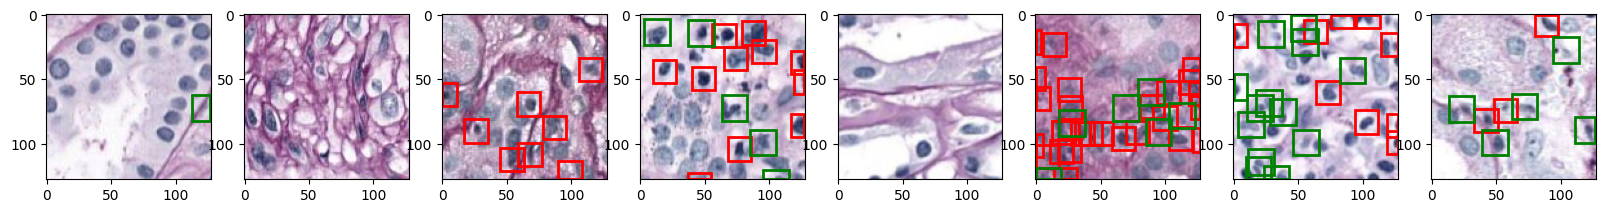

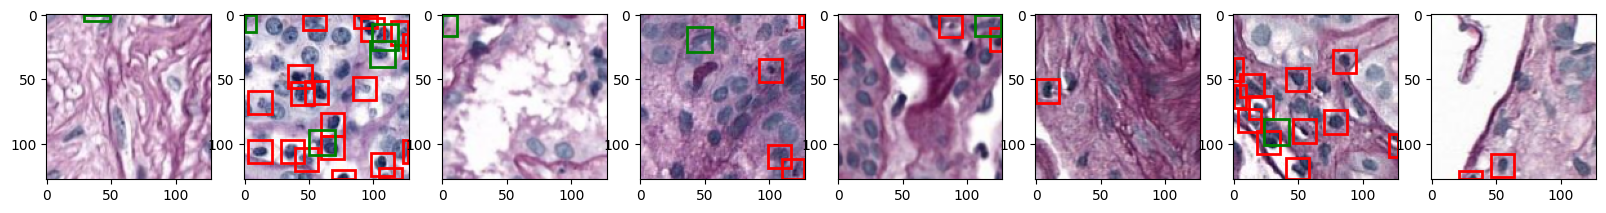

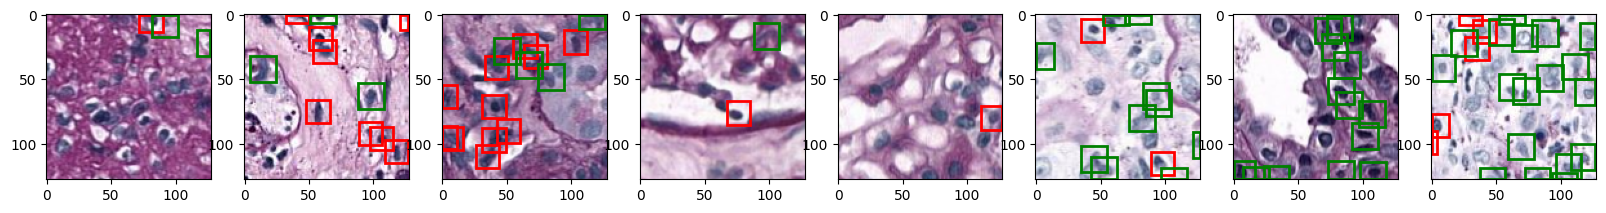

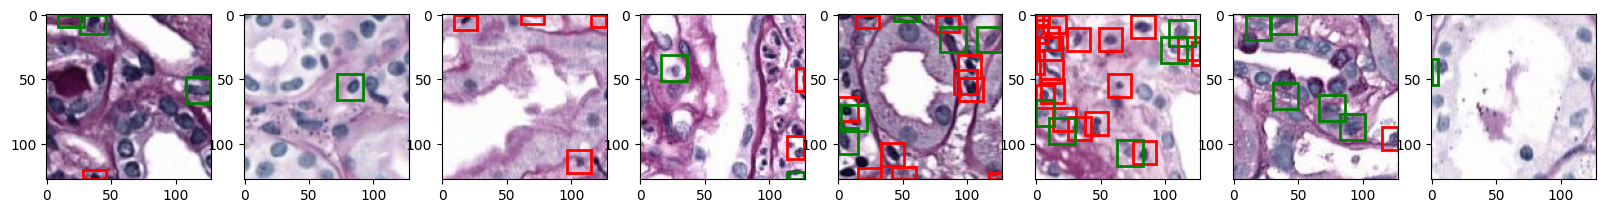

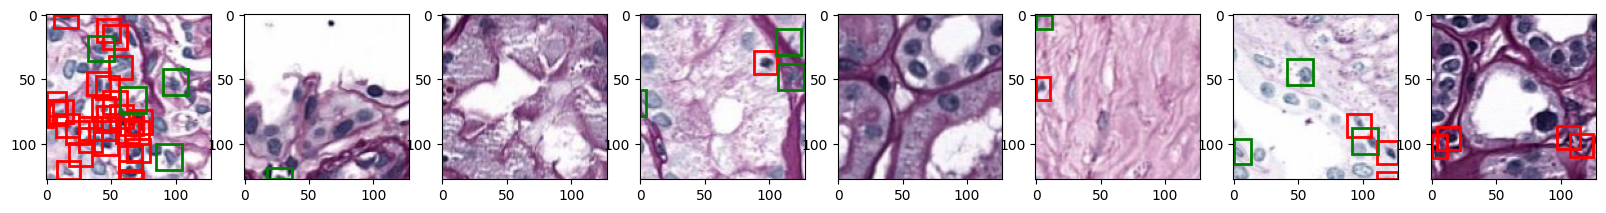

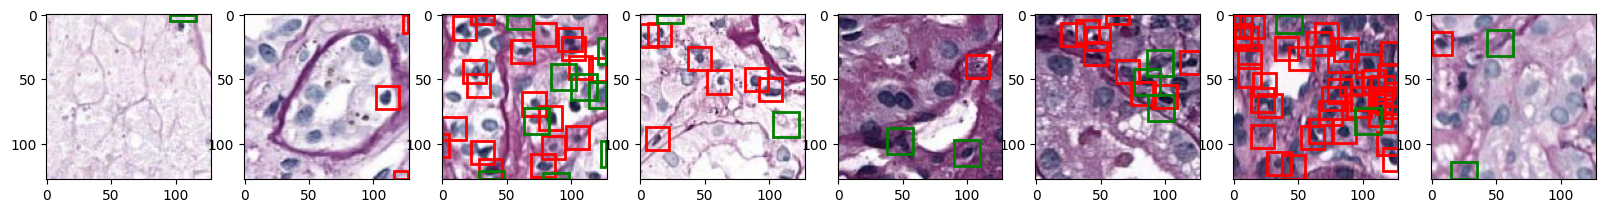

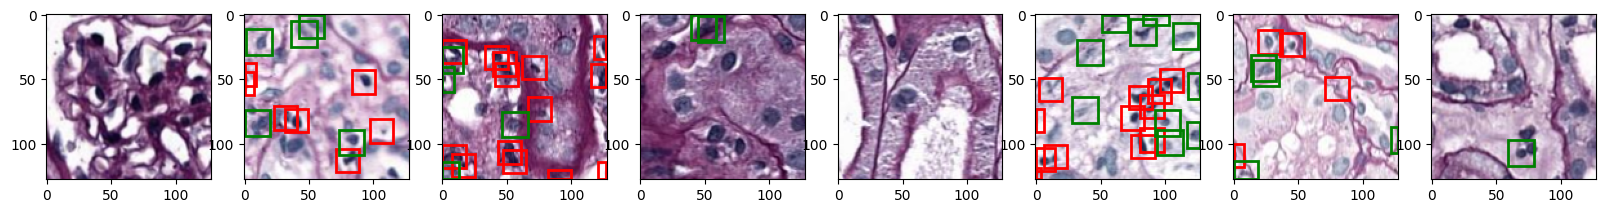

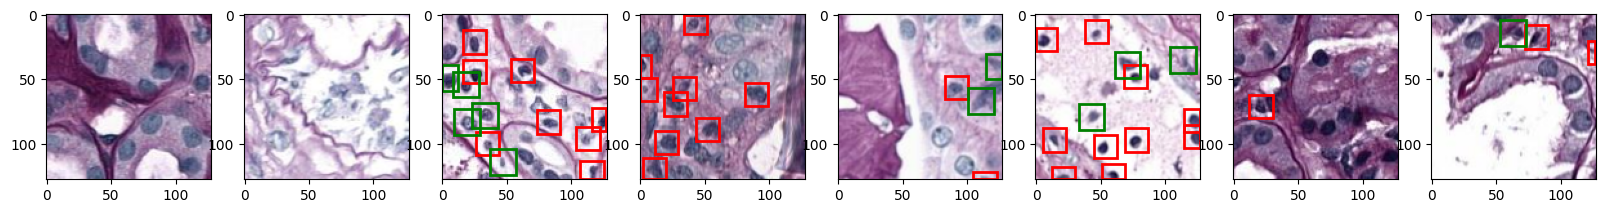

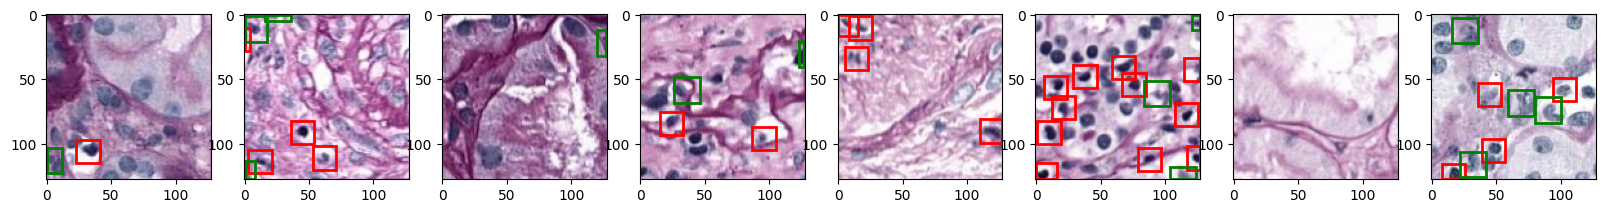

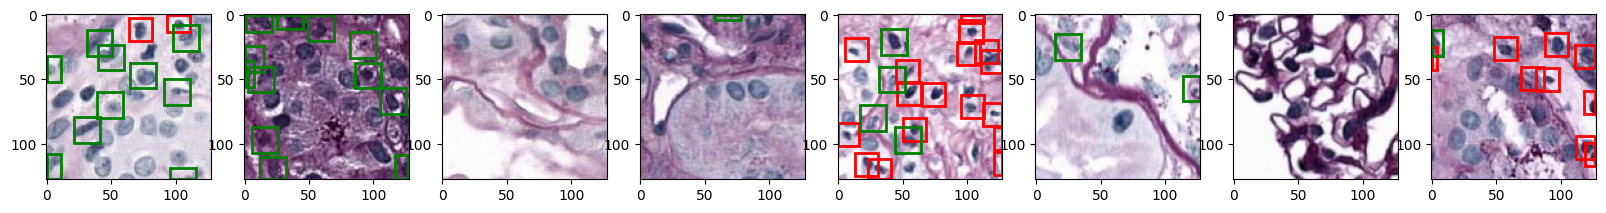

In [8]:


# Create a colormap that maps index 0 -> red, index 1 -> green
color_map = ListedColormap(["red", "green"])


def plot_boxes_labels(
    boxes, max_width, max_height, axes=None, output_shape=None, color_map=None
):
    if axes is None:
        _, ax = plt.subplots(1, 1)
    else:
        ax = axes

    # If no color_map provided, use 'tab10' by default
    if color_map is None:
        color_map = plt.cm.get_cmap("tab10")

    for box in boxes:
        x1, y1, x2, y2, label_value, confidence = box
        label_value = int(label_value)  # Ensure label is an int for indexing colormap
        color = color_map(label_value % color_map.N)

        # Plot the box if coordinates are valid
        if (x1, y1, x2, y2) != (0, 0, 0, 0):
            rect = pltpatches.Rectangle(
                (x1, y1),
                min(max_width, max(0, x2 - x1)),
                min(max_height, max(0, y2 - y1)),
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

            # Optional: add label text
            # ax.text(
            #     x1, y1 - 3, f'Class: {label_value}',
            #     color=color,
            #     fontsize=10,
            #     fontweight='bold',
            #     va='bottom', ha='left',
            #     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
            # )

    if axes is None:
        plt.show()


# Example usage with batch_dicts:
for _ in range(10):
    batch_dicts = next(training_batch_generator)
    fig, ax = plt.subplots(1, 8, figsize=(20, 10))
    for i in range(8):
        # Convert PyTorch tensor image to NumPy
        patch = (
            batch_dicts[i]["image"]
            .cpu()
            .detach()
            .numpy()
            .transpose(1, 2, 0)
            .astype("uint8")
        )

        # Extract boxes and classes
        _boxes = batch_dicts[i]["instances"].gt_boxes.tensor.cpu().detach().numpy()
        gt_classes = batch_dicts[i]["instances"].gt_classes.cpu().detach().numpy()

        # Construct the boxes array with label and dummy confidence
        boxes = np.zeros((len(_boxes), 6))
        boxes[:, :4] = _boxes
        boxes[:, 4] = gt_classes
        boxes[:, 5] = 1.0  # dummy confidence

        max_width, max_height = batch_dicts[i]["instances"].image_size
        ax[i].imshow(patch)
        # Pass a colormap object, not a string
        plot_boxes_labels(
            boxes,
            max_width=max_width,
            max_height=max_height,
            axes=ax[i],
            color_map=color_map,
        )
    plt.show()

Creating the output folder for saving the model and results.

In [9]:
output_folder = Path("./outputs")
if not (os.path.isdir(output_folder)):
    os.mkdir(output_folder)
cpus = 4

# Train the model

In [10]:
cfg = get_cfg()
# using faster rcnn architecture
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
)  # download the model weights to fine-tune
cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # was 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # was 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 2000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = (10, 100, 250)
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

#save the config file
cfg_file = output_folder / "config.yaml"
with open(cfg_file, "w") as f:
    f.write(cfg.dump())

In [11]:
model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

trainer = WholeSlideDectectron2Trainer(cfg, user_config=user_config, cpus=cpus)
trainer.resume_or_load(resume=False)
trainer.train()

Parameter Count:
103967288
[12/10 16:37:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
 

Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (36, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible s

[12/10 16:37:39 d2.engine.train_loop]: Starting training from iteration 0


/venv/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/10 16:38:29 d2.utils.events]:  eta: 0:31:16  iter: 19  total_loss: 1.178  loss_cls: 0.3686  loss_box_reg: 0.2682  loss_rpn_cls: 0.451  loss_rpn_loc: 0.04588  time: 0.9414  data_time: 1.2712  lr: 0.0005  max_mem: 2534M
[12/10 16:38:49 d2.utils.events]:  eta: 0:31:02  iter: 39  total_loss: 0.8895  loss_cls: 0.3376  loss_box_reg: 0.2818  loss_rpn_cls: 0.2428  loss_rpn_loc: 0.03912  time: 0.9614  data_time: 0.0040  lr: 0.0005  max_mem: 2534M
[12/10 16:39:08 d2.utils.events]:  eta: 0:30:43  iter: 59  total_loss: 0.9633  loss_cls: 0.3723  loss_box_reg: 0.3213  loss_rpn_cls: 0.2133  loss_rpn_loc: 0.03721  time: 0.9651  data_time: 0.0044  lr: 0.0005  max_mem: 2534M
[12/10 16:39:28 d2.utils.events]:  eta: 0:30:24  iter: 79  total_loss: 0.9001  loss_cls: 0.3505  loss_box_reg: 0.3317  loss_rpn_cls: 0.1865  loss_rpn_loc: 0.03496  time: 0.9676  data_time: 0.0041  lr: 0.0005  max_mem: 2534M
[12/10 16:39:46 d2.utils.events]:  eta: 0:30:05  iter: 99  total_loss: 0.8941  loss_cls: 0.348  loss_box_r

Evaluation.

In [10]:
cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 24, 32]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300  # was 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1

cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_final.pth")

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

Parameter Count:
103967288


In [13]:
# predictor = Detectron2DetectionPredictor(cfg)
# with create_batch_iterator(
#     user_config=user_config,
#     mode='training',
#     cpus=4,
# ) as training_batch_generator:
#     for _ in range(5):
#         fig, ax = plt.subplots(1,5, figsize=(20,10))
#         batch_x, batch_y, info = next(training_batch_generator)
#         predicted_batch = predictor.predict_on_batch(batch_x)
#         for i in range(5):
#             patch = batch_x[i]
#             boxes =  predicted_batch[i]['boxes']
#             confidences = predicted_batch[i]['confidences']
#             filtered_boxes = []
#             for box, confidence in zip(boxes, confidences):
#                 if confidence > 0.3:
#                     filtered_boxes.append(box)
#             ax[i].imshow(patch)
#             plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[i])
#         plt.show()

/venv/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/venv/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


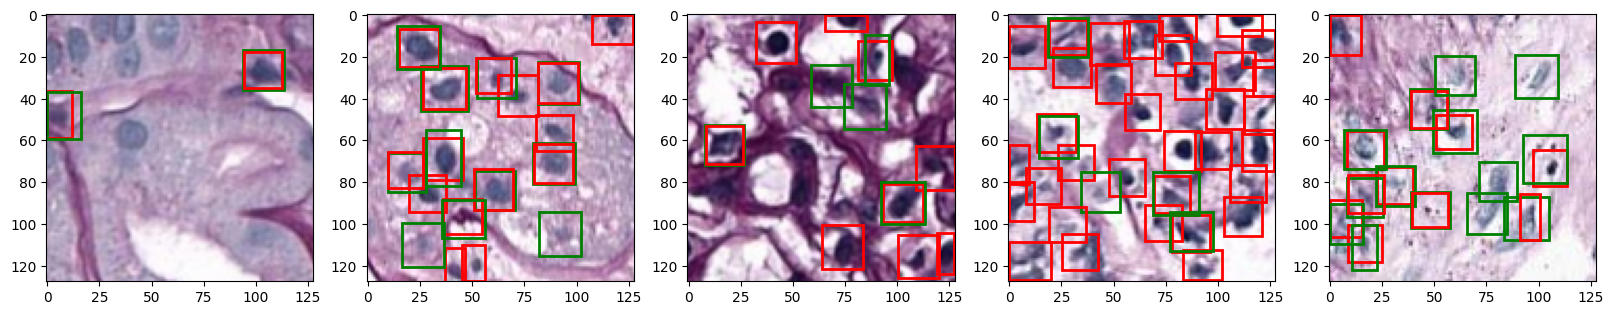

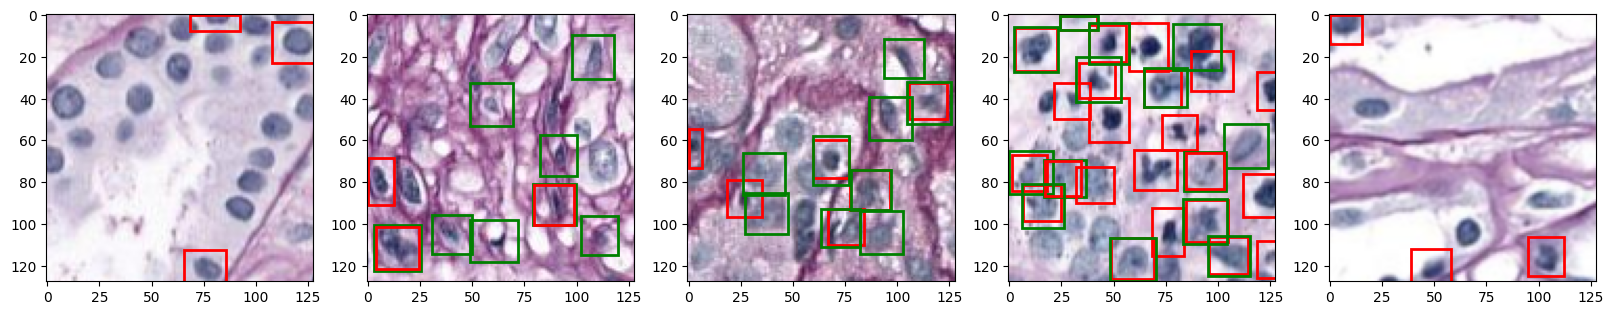

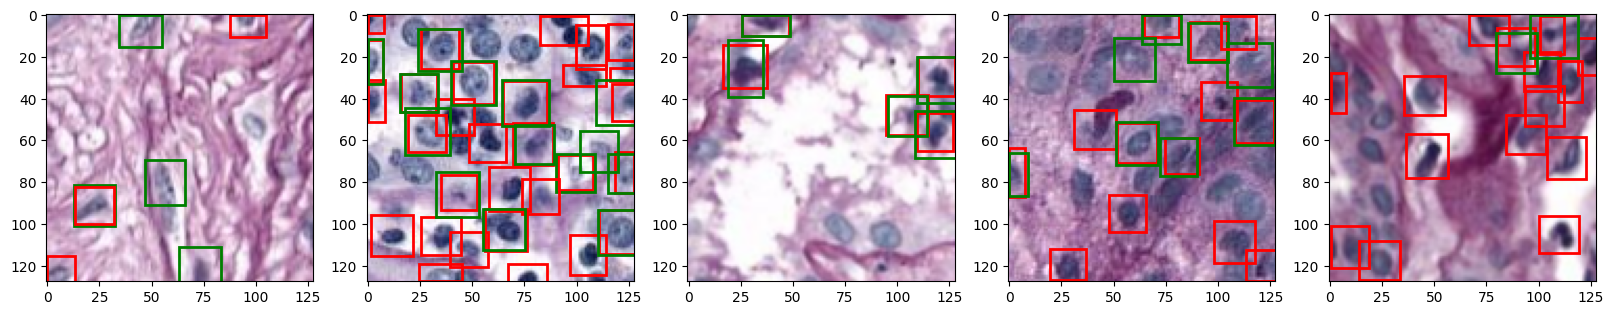

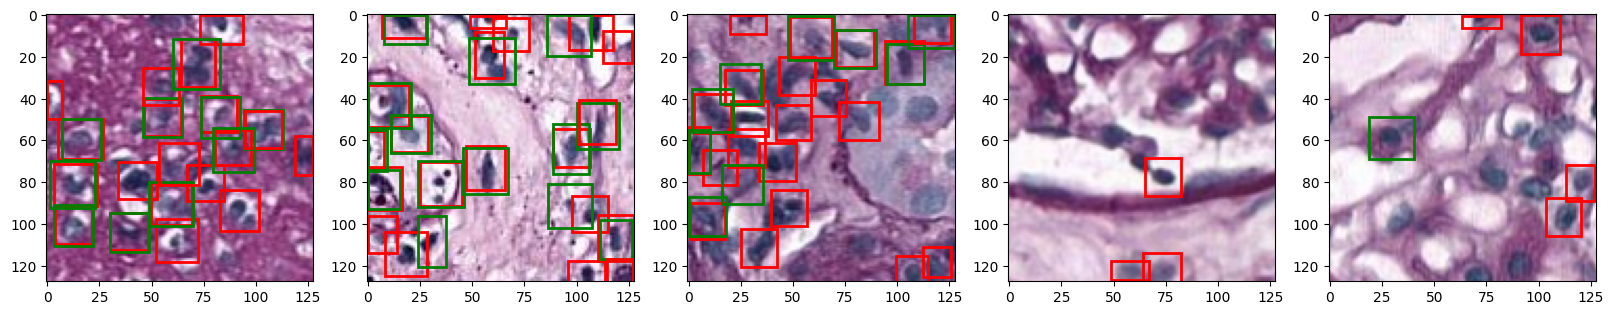

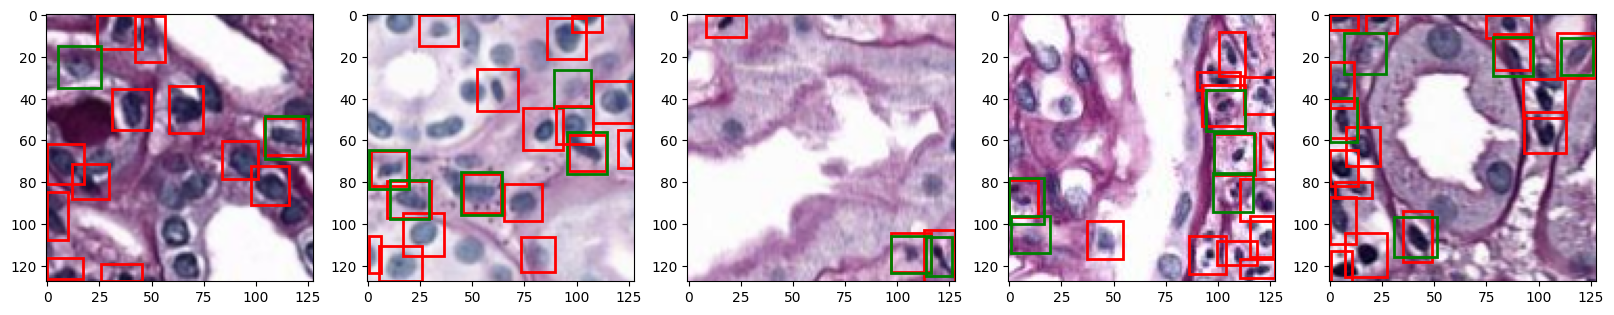

In [11]:


CONF_TRESH = 0.2


def plot_boxes_labels(
    boxes, max_width, max_height, axes=None, output_shape=None, color_map=None
):
    """
    Plots bounding boxes on an image (axes) with colors determined by class labels.

    Parameters
    ----------
    boxes : array-like
        Nx6 array: [x1, y1, x2, y2, label, confidence].
    max_width : int
        Maximum width to consider for clamping the box size.
    max_height : int
        Maximum height to consider for clamping the box size.
    axes : matplotlib.axes.Axes, optional
        The Axes object on which to draw.
    output_shape : tuple, optional
        Not used, included for interface consistency.
    color_map : matplotlib.colors.Colormap, optional
        A colormap to use for coloring boxes. Defaults to two-class: red/green.
    """
    if axes is None:
        fig, ax = plt.subplots(1, 1)
    else:
        ax = axes

    # Default to a simple two-color map: class 0 = red, class 1 = green
    if color_map is None:
        color_map = ListedColormap(["red", "green"])

    for box in boxes:
        x1, y1, x2, y2, label_value, confidence = box
        label_value = int(label_value)
        color = color_map(label_value % color_map.N)

        # Check if coordinates are valid
        if (x1, y1, x2, y2) != (0, 0, 0, 0):
            width = min(max_width, max(0, x2 - x1))
            height = min(max_height, max(0, y2 - y1))

            rect = pltpatches.Rectangle(
                (x1, y1),
                width,
                height,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

    if axes is None:
        plt.show()


# Use a custom two-class colormap: class 0 = red, class 1 = green
color_map = ListedColormap(["red", "green"])

predictor = Detectron2DetectionPredictor(cfg)
with create_batch_iterator(
    user_config=user_config,
    mode="training",
    cpus=4,
) as training_batch_generator:
    for _ in range(5):
        fig, ax = plt.subplots(1, 5, figsize=(20, 10))
        batch_x, batch_y, info = next(training_batch_generator)
        predicted_batch = predictor.predict_on_batch(batch_x)

        for i in range(5):
            patch = batch_x[i]
            pred = predicted_batch[i]

            boxes_raw = pred["boxes"]  # e.g., list of [x1, y1, x2, y2, ...]
            classes_raw = pred["classes"]  # class indices
            confidences_raw = pred["confidences"]  # confidences

            num_boxes = len(boxes_raw)
            boxes = np.zeros((num_boxes, 6))
            for idx in range(num_boxes):
                x1, y1, x2, y2 = boxes_raw[idx][:4]
                label = int(classes_raw[idx])
                confidence = float(confidences_raw[idx])

                # print(f"Box {idx}: ({x1}, {y1}) -> ({x2}, {y2}), Label: {label}, Confidence: {confidence}")

                boxes[idx, :4] = [x1, y1, x2, y2]
                boxes[idx, 4] = label
                boxes[idx, 5] = confidence

            # Filter by confidence threshold
            confident_boxes = boxes[boxes[:, 5] > CONF_TRESH]

            ax[i].imshow(patch)
            if len(confident_boxes) > 0:
                plot_boxes_labels(
                    confident_boxes,
                    max_width=64,
                    max_height=64,
                    axes=ax[i],
                    color_map=color_map,
                )
        plt.show()